# Linear network training and replay

In [142]:
from yawning_titan.networks.node import Node
from yawning_titan.networks.network import Network

import time
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor
from stable_baselines3 import A2C, DQN, PPO
from stable_baselines3.ppo import MlpPolicy as PPOMlp

from yawning_titan.envs.generic.core.blue_interface import BlueInterface
from yawning_titan.envs.generic.core.red_interface import RedInterface
from yawning_titan.envs.generic.generic_env import GenericNetworkEnv
from yawning_titan.envs.generic.core.action_loops import ActionLoop
from yawning_titan.envs.generic.core.network_interface import NetworkInterface
from yawning_titan.networks.network_db import default_18_node_network
import yawning_titan.game_modes
from yawning_titan.envs.generic.core.action_loops import ActionLoop

## Using DB to retrieve game modes
from yawning_titan.game_modes.game_mode_db import GameModeDB, GameModeSchema
from yawning_titan.db.doc_metadata import DocMetadataSchema
db = GameModeDB()

### Network Setup

Network of 5 nodes, connected in a line. Node 1 is the entry node and node 5 is the high value target. All nodes begin with an initial vulnerability of 0.3.

In [143]:
# Instantiate the Network
network = Network()

# Instantiate the Node's and add them to the Network
 
pc_1 = Node("PC 1")
network.add_node(pc_1)
pc_1.x_pos = -1.00
pc_1.y_pos = 0.01
pc_1.entry_node = True
pc_1.vulnerability = 0.8

pc_2 = Node("PC 2")
network.add_node(pc_2)
pc_2.x_pos = -0.50
pc_2.y_pos = 0.01
pc_2.vulnerability = 0.8

pc_3 = Node("PC 3")
network.add_node(pc_3)
pc_3.x_pos = 0.00
pc_3.y_pos = 0.01
pc_3.vulnerability = 0.8

pc_4 = Node("PC 4")
network.add_node(pc_4)
pc_4.x_pos = 0.50
pc_4.y_pos = 0.01
pc_4.vulnerability = 0.8

pc_5 = Node("PC 5")
network.add_node(pc_5)
pc_5.x_pos = 1.00
pc_5.y_pos = 0.01
pc_5.high_value_node = True
pc_5.vulnerability = 0.8


# Add the edges between Node's
network.add_edge(pc_1, pc_2)
network.add_edge(pc_2, pc_3)
network.add_edge(pc_3, pc_4)
network.add_edge(pc_4, pc_5)



# Reset the entry nodes, high value nodes, and vulnerability scores by calling .setup()
# network.reset()

# View the Networks Node Details
network.show(verbose=True)

UUID                                  Name    High Value Node    Entry Node      Vulnerability  Position (x,y)
------------------------------------  ------  -----------------  ------------  ---------------  ----------------
61afecab-44cd-4122-a9db-72b09f7c672b  PC 1    False              True                      0.8  -1.00, 0.01
c09a02e0-1beb-47dd-9170-fa80d2004779  PC 2    False              False                     0.8  -0.50, 0.01
d2017035-2065-4f0d-8345-aee33ca332b3  PC 3    False              False                     0.8  0.00, 0.01
e1f888b3-67bf-4b0c-a2d8-699aed93a050  PC 4    False              False                     0.8  0.50, 0.01
97ba1a33-13dc-48c2-8095-884d14d65ba8  PC 5    True               False                     0.8  1.00, 0.01


## Creating environments and training

In [3]:
# load notebook extension
%reload_ext tensorboard

In [144]:
db.show(True)

name               author              locked    uuid
-----------------  ------------------  --------  ------------------------------------
DCBO Agent Config  dstl/YAWNING-TITAN  True      bac2cb9d-b24b-426c-88a5-5edd0c2de413
Default Game Mode  dstl/YAWNING-TITAN  True      900a704f-6271-4994-ade7-40b74d3199b1
Low skill red      dstl/YAWNING-TITAN  True      3ccd9988-8781-4c3e-9c75-44cc987ae6af
XAI_mode           H Harrison          False     f5665563-d91a-4164-9e19-c67ce3db0066


### Game mode

#### Red: 

Can attack from any node it controls 

Only basic attack and zero day enabled. 

Starts with one zero day attack and gains another every 5 timesteps 

No natural spreading 

Target mechanism: (prioritise vulnerable nodes – sorts nodes it can attack and selects most vulnerable) changed to random 

#### Blue: 

Action set: reduce vulnerability, restore node (considering taking away restore node as kept winning by immediately restoring first node red attacks) 

100% chance of immediately discovering intrusions 

#### Game rules: 

Max steps: 30, no grace period 

Blue loss if high value node lost

#### Observation space 

Compromised status, vulnerability scores and node connections. I removed special nodes as this is kind of inferred by the rewards and adds a lot of dimensions.

#### Rewards 

-100 for loss, 100 for reaching end.  

Negative reward reduced for closer fails – if closer to end of timesteps 


In [145]:
simple_mode = db.get("f5665563-d91a-4164-9e19-c67ce3db0066")

In [146]:
## Build network interface
s_network_interface = NetworkInterface(game_mode=simple_mode, network=network)

## Name agents
red = RedInterface(s_network_interface)
blue = BlueInterface(s_network_interface)

## Create environment
s_env = GenericNetworkEnv(red, blue, s_network_interface)

## Check compliant with OpenAI gym
check_env(s_env, warn=True)
_ = s_env.reset()

In [7]:
## Initialise environment callback
eval_callback = EvalCallback(Monitor(s_env), eval_freq=1000, deterministic=False, render=False)

## Create agent
s_agent = PPO(PPOMlp, s_env, verbose=1, tensorboard_log="./logs/tensorboard_t2/")

## Train agent for 200,000 timesteps
s_agent.learn(total_timesteps=200000, n_eval_episodes=1, callback=eval_callback)
%tensorboard --logdir ./logs/tensorboard_t2/

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/tensorboard_t2/PPO_2
Eval num_timesteps=1000, episode_reward=-38.59 +/- 5.47
Episode length: 13.20 +/- 4.26
---------------------------------
| eval/              |          |
|    mean_ep_length  | 13.2     |
|    mean_reward     | -38.6    |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-42.55 +/- 5.72
Episode length: 10.20 +/- 2.32
---------------------------------
| eval/              |          |
|    mean_ep_length  | 10.2     |
|    mean_reward     | -42.5    |
| time/              |          |
|    total_timesteps | 2000     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 11.9     |
|    ep_rew_mean     | -39.2    |
| time/              |          |
|    fps             | 87

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 15       |
|    ep_rew_mean     | -28.2    |
| time/              |          |
|    fps             | 662      |
|    iterations      | 6        |
|    time_elapsed    | 18       |
|    total_timesteps | 12288    |
---------------------------------
Eval num_timesteps=13000, episode_reward=-7.49 +/- 33.98
Episode length: 20.20 +/- 8.98
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 20.2        |
|    mean_reward          | -7.49       |
| time/                   |             |
|    total_timesteps      | 13000       |
| train/                  |             |
|    approx_kl            | 0.008378647 |
|    clip_fraction        | 0.0186      |
|    clip_range           | 0.2         |
|    entropy_loss         | -2.13       |
|    explained_variance   | 0.518       |
|    learning_rate        | 0.0003      |
|    loss                 

Eval num_timesteps=24000, episode_reward=-32.48 +/- 12.46
Episode length: 14.20 +/- 8.38
---------------------------------
| eval/              |          |
|    mean_ep_length  | 14.2     |
|    mean_reward     | -32.5    |
| time/              |          |
|    total_timesteps | 24000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 18.9     |
|    ep_rew_mean     | -14.9    |
| time/              |          |
|    fps             | 645      |
|    iterations      | 12       |
|    time_elapsed    | 38       |
|    total_timesteps | 24576    |
---------------------------------
Eval num_timesteps=25000, episode_reward=3.93 +/- 38.43
Episode length: 22.40 +/- 8.55
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 22.4       |
|    mean_reward          | 3.93       |
| time/                   |            |
|    total_timesteps      | 25000      |


Eval num_timesteps=35000, episode_reward=15.66 +/- 36.75
Episode length: 23.80 +/- 7.65
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 23.8        |
|    mean_reward          | 15.7        |
| time/                   |             |
|    total_timesteps      | 35000       |
| train/                  |             |
|    approx_kl            | 0.011489149 |
|    clip_fraction        | 0.0732      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.61       |
|    explained_variance   | 0.503       |
|    learning_rate        | 0.0003      |
|    loss                 | 205         |
|    n_updates            | 170         |
|    policy_gradient_loss | -0.0164     |
|    value_loss           | 288         |
-----------------------------------------
Eval num_timesteps=36000, episode_reward=50.65 +/- 6.50
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|

Eval num_timesteps=47000, episode_reward=6.38 +/- 37.21
Episode length: 20.40 +/- 8.36
---------------------------------
| eval/              |          |
|    mean_ep_length  | 20.4     |
|    mean_reward     | 6.38     |
| time/              |          |
|    total_timesteps | 47000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 28.6     |
|    ep_rew_mean     | 42       |
| time/              |          |
|    fps             | 631      |
|    iterations      | 23       |
|    time_elapsed    | 74       |
|    total_timesteps | 47104    |
---------------------------------
Eval num_timesteps=48000, episode_reward=57.48 +/- 4.82
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 57.5        |
| time/                   |             |
|    total_timesteps      | 48000     

Eval num_timesteps=58000, episode_reward=39.50 +/- 36.50
Episode length: 25.80 +/- 8.40
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 25.8         |
|    mean_reward          | 39.5         |
| time/                   |              |
|    total_timesteps      | 58000        |
| train/                  |              |
|    approx_kl            | 0.0071894545 |
|    clip_fraction        | 0.0825       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.09        |
|    explained_variance   | 0.148        |
|    learning_rate        | 0.0003       |
|    loss                 | 51.6         |
|    n_updates            | 280          |
|    policy_gradient_loss | -0.00994     |
|    value_loss           | 121          |
------------------------------------------
Eval num_timesteps=59000, episode_reward=58.23 +/- 0.87
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/          

Eval num_timesteps=69000, episode_reward=44.03 +/- 33.70
Episode length: 26.80 +/- 6.40
---------------------------------
| eval/              |          |
|    mean_ep_length  | 26.8     |
|    mean_reward     | 44       |
| time/              |          |
|    total_timesteps | 69000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | 51.9     |
| time/              |          |
|    fps             | 626      |
|    iterations      | 34       |
|    time_elapsed    | 111      |
|    total_timesteps | 69632    |
---------------------------------
Eval num_timesteps=70000, episode_reward=57.41 +/- 3.70
Episode length: 30.00 +/- 0.00
----------------------------------------
| eval/                   |            |
|    mean_ep_length       | 30         |
|    mean_reward          | 57.4       |
| time/                   |            |
|    total_timesteps      | 70000      |
|

Eval num_timesteps=80000, episode_reward=58.95 +/- 1.72
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 58.9        |
| time/                   |             |
|    total_timesteps      | 80000       |
| train/                  |             |
|    approx_kl            | 0.012373822 |
|    clip_fraction        | 0.092       |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.755      |
|    explained_variance   | 0.0815      |
|    learning_rate        | 0.0003      |
|    loss                 | 63          |
|    n_updates            | 390         |
|    policy_gradient_loss | -0.0046     |
|    value_loss           | 57.4        |
-----------------------------------------
Eval num_timesteps=81000, episode_reward=60.49 +/- 1.13
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
| 

New best mean reward!
Eval num_timesteps=92000, episode_reward=59.93 +/- 1.59
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 59.9     |
| time/              |          |
|    total_timesteps | 92000    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | 55.1     |
| time/              |          |
|    fps             | 622      |
|    iterations      | 45       |
|    time_elapsed    | 147      |
|    total_timesteps | 92160    |
---------------------------------
Eval num_timesteps=93000, episode_reward=59.71 +/- 1.51
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 59.7        |
| time/                   |             |
|    total_times

Eval num_timesteps=103000, episode_reward=40.01 +/- 5.98
Episode length: 30.00 +/- 0.00
---------------------------------------
| eval/                   |           |
|    mean_ep_length       | 30        |
|    mean_reward          | 40        |
| time/                   |           |
|    total_timesteps      | 103000    |
| train/                  |           |
|    approx_kl            | 0.2667458 |
|    clip_fraction        | 0.223     |
|    clip_range           | 0.2       |
|    entropy_loss         | -0.782    |
|    explained_variance   | 0.083     |
|    learning_rate        | 0.0003    |
|    loss                 | 0.286     |
|    n_updates            | 500       |
|    policy_gradient_loss | -0.0175   |
|    value_loss           | 19        |
---------------------------------------
Eval num_timesteps=104000, episode_reward=45.22 +/- 2.07
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
| 

Eval num_timesteps=114000, episode_reward=57.10 +/- 4.84
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 57.1     |
| time/              |          |
|    total_timesteps | 114000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 54.3     |
| time/              |          |
|    fps             | 620      |
|    iterations      | 56       |
|    time_elapsed    | 184      |
|    total_timesteps | 114688   |
---------------------------------
Eval num_timesteps=115000, episode_reward=57.09 +/- 4.68
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 57.1        |
| time/                   |             |
|    total_timesteps      | 115000  

Eval num_timesteps=125000, episode_reward=58.51 +/- 3.01
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 58.5         |
| time/                   |              |
|    total_timesteps      | 125000       |
| train/                  |              |
|    approx_kl            | 0.0066560335 |
|    clip_fraction        | 0.0459       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.656       |
|    explained_variance   | 0.0565       |
|    learning_rate        | 0.0003       |
|    loss                 | 12.6         |
|    n_updates            | 610          |
|    policy_gradient_loss | -0.00264     |
|    value_loss           | 47.1         |
------------------------------------------
Eval num_timesteps=126000, episode_reward=60.06 +/- 2.08
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=137000, episode_reward=59.99 +/- 1.73
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 60       |
| time/              |          |
|    total_timesteps | 137000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 30       |
|    ep_rew_mean     | 57.2     |
| time/              |          |
|    fps             | 612      |
|    iterations      | 67       |
|    time_elapsed    | 223      |
|    total_timesteps | 137216   |
---------------------------------
Eval num_timesteps=138000, episode_reward=58.29 +/- 3.69
Episode length: 30.00 +/- 0.00
-----------------------------------------
| eval/                   |             |
|    mean_ep_length       | 30          |
|    mean_reward          | 58.3        |
| time/                   |             |
|    total_timesteps      | 138000  

Eval num_timesteps=148000, episode_reward=61.15 +/- 0.65
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 61.2         |
| time/                   |              |
|    total_timesteps      | 148000       |
| train/                  |              |
|    approx_kl            | 0.0051841964 |
|    clip_fraction        | 0.0499       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.66        |
|    explained_variance   | 0.0554       |
|    learning_rate        | 0.0003       |
|    loss                 | 55           |
|    n_updates            | 720          |
|    policy_gradient_loss | -0.00334     |
|    value_loss           | 36.6         |
------------------------------------------
Eval num_timesteps=149000, episode_reward=60.97 +/- 0.53
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=159000, episode_reward=56.72 +/- 4.05
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 56.7     |
| time/              |          |
|    total_timesteps | 159000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.5     |
|    ep_rew_mean     | 57       |
| time/              |          |
|    fps             | 611      |
|    iterations      | 78       |
|    time_elapsed    | 261      |
|    total_timesteps | 159744   |
---------------------------------
Eval num_timesteps=160000, episode_reward=59.08 +/- 3.26
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 59.1         |
| time/                   |              |
|    total_timesteps      | 160

Eval num_timesteps=170000, episode_reward=60.81 +/- 0.63
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 60.8         |
| time/                   |              |
|    total_timesteps      | 170000       |
| train/                  |              |
|    approx_kl            | 0.0056622988 |
|    clip_fraction        | 0.0771       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.827       |
|    explained_variance   | 0.0683       |
|    learning_rate        | 0.0003       |
|    loss                 | 58.8         |
|    n_updates            | 830          |
|    policy_gradient_loss | -0.00157     |
|    value_loss           | 57.5         |
------------------------------------------
Eval num_timesteps=171000, episode_reward=59.82 +/- 1.79
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/         

Eval num_timesteps=182000, episode_reward=60.81 +/- 1.09
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/              |          |
|    mean_ep_length  | 30       |
|    mean_reward     | 60.8     |
| time/              |          |
|    total_timesteps | 182000   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | 56.6     |
| time/              |          |
|    fps             | 607      |
|    iterations      | 89       |
|    time_elapsed    | 300      |
|    total_timesteps | 182272   |
---------------------------------
Eval num_timesteps=183000, episode_reward=61.36 +/- 0.33
Episode length: 30.00 +/- 0.00
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 30           |
|    mean_reward          | 61.4         |
| time/                   |              |
|    total_timesteps      | 183

Eval num_timesteps=193000, episode_reward=43.92 +/- 34.62
Episode length: 26.60 +/- 6.80
------------------------------------------
| eval/                   |              |
|    mean_ep_length       | 26.6         |
|    mean_reward          | 43.9         |
| time/                   |              |
|    total_timesteps      | 193000       |
| train/                  |              |
|    approx_kl            | 0.0044886377 |
|    clip_fraction        | 0.0575       |
|    clip_range           | 0.2          |
|    entropy_loss         | -0.663       |
|    explained_variance   | 0.0504       |
|    learning_rate        | 0.0003       |
|    loss                 | 1.28         |
|    n_updates            | 940          |
|    policy_gradient_loss | -0.000726    |
|    value_loss           | 73.9         |
------------------------------------------
Eval num_timesteps=194000, episode_reward=60.36 +/- 1.44
Episode length: 30.00 +/- 0.00
---------------------------------
| eval/        

In [8]:
## Save trained agent
s_agent_name = "ppo-s-linear"
s_agent.save(s_agent_name)

In [147]:
# Evaluation 

# Create a new environment for evaluation
eval_env =GenericNetworkEnv(red, blue, s_network_interface)

# Evaluate the model with 10 evaluation episodes and deterministic=True
mean_reward, std_reward = evaluate_policy(s_agent, eval_env, n_eval_episodes=10, deterministic=True)

# Print the results
print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

2023-08-22 10:03:11,553::WARNING::py.warnings::_showwarnmsg::109::C:\Users\Stephen Day\yawning_titan\.venv\lib\site-packages\stable_baselines3\common\evaluation.py:65: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(



mean_reward=13.55 +/- 9.025758867379775


MoviePy - Building file  .\gifs\None_19-08-2023_17-18_1.webm
MoviePy - - Generating GIF frames.


MoviePy - - File ready: .\gifs\None_19-08-2023_17-18_1.webm.


[   action  rewards                                               info
 0       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 1       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 2       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 3       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 4       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 5       0   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 6       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 7       1   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 8       3   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 9       5   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 10      3   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 11      4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 12      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
 13   

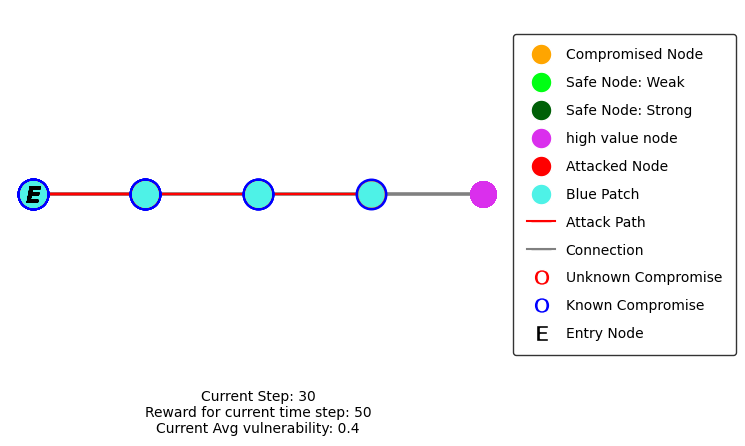

In [139]:
# Create gif
eval_env.reset()
loop = ActionLoop(eval_env, s_agent, episode_count=1)
loop.gif_action_loop(save_gif=True, render_network=True, gif_output_directory='.\gifs', webm_output_directory='.\gifs')

In [11]:
loop = ActionLoop(eval_env, s_agent, episode_count=1)
print(loop)

## Replay

In [82]:
import pandas as pd

In [119]:
        complete_results = []
        for i in range(2000):
            results = pd.DataFrame(
                columns=["action", "rewards", "info", "old_state", "new_state"], dtype = object
            )  
            obs = eval_env.reset()
            done = False

            while not done:
                # gets the agents prediction for the best next action to take
                old_state = obs
                action, _states = s_agent.predict(obs, deterministic= True)

                # step the env
                obs, rewards, done, info = eval_env.step(action)

                results.loc[len(results.index)] = [action, rewards, info, old_state, obs]

            complete_results.append(results)

In [120]:
complete_results[1]

action  rewards                                               info  \
0       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
1       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
2       1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
3       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
4       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
5       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
6       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
7       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
8       1   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
9       3   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
10      7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
11      0   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
12      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
13      1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
14      4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
15      8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
16      7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
17      0   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
18      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
19      1   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
20      7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
21      2   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
22      0   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
23      6   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
24      6   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
25      7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
26      6   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
27      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
28      1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
29      2  50.0000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   

                                            old_state  \
0   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
1   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
2   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
3   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
4   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
5   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
6   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
7   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
8   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
9   [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
10  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
11  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
12  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
13  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
14  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
15  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
16  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
17  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
18  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
19  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
20  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
21  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
22  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
23  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
24  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
25  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
26  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
27  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
28  [0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...   
29  [0.0, 1.0, 0.0, 0.0, 0.0,

In [85]:
complete_results[1]['info'][11]

{'initial_state': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0,
  '51ca4906-074f-4855-9fd9-0a16e76a77ca': 0,
  '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0,
  '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0,
  'f16940e7-9b3b-438c-b34f-832030c0ea80': 0},
 'initial_blue_view': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0,
  '51ca4906-074f-4855-9fd9-0a16e76a77ca': 0,
  '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0,
  '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0,
  'f16940e7-9b3b-438c-b34f-832030c0ea80': 0},
 'initial_vulnerabilities': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0.8,
  '51ca4906-074f-4855-9fd9-0a16e76a77ca': 0.6000000000000001,
  '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0.8,
  '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0.20000000000000007,
  'f16940e7-9b3b-438c-b34f-832030c0ea80': 0.4000000000000001},
 'initial_red_location': None,
 'initial_graph': {Node(uuid='86291e7c-5b6a-4c23-bd0c-094e933ae5e6', name='PC 1', high_value_node=False, entry_node=True, vulnerability=0.8, x_pos=-1.0, y_pos=0.01): {Nod

In [86]:
complete_results[1]['new_state'][11]


array([0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. ,
       1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. ,
       0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0.8, 0.6, 0.8, 0.2,
       0.2, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
      dtype=float32)

In [87]:
complete_results


[   action  rewards                                               info  \
 0       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 1       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 2       1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 3       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 4       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 5       1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 6       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 7       7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 8       1   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 9       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 10      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 11      1   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...   
 12      7   0.4231  {'initial_state':

In [88]:
timestep = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        info = complete_results[i]['info'][j]
        index = complete_results[i][complete_results[i]['info'] == info].index[0]
        timestep.append(index)


In [89]:
print(len(timestep))

58646


In [90]:
action = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        act = int(complete_results[i]['action'][j])
        action.append(act)

In [91]:
int(complete_results[1]['action'][0])

4

In [92]:
import numpy as np
x =np.array(action) 
np.unique(x)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [93]:
print(action)


[4, 7, 1, 8, 7, 1, 4, 7, 1, 8, 7, 1, 7, 1, 3, 1, 7, 0, 7, 1, 7, 4, 8, 7, 0, 7, 2, 7, 0, 6, 4, 7, 8, 7, 4, 8, 7, 1, 0, 4, 7, 8, 7, 1, 0, 2, 0, 6, 6, 7, 1, 6, 2, 6, 7, 1, 3, 6, 6, 6, 4, 7, 8, 4, 8, 7, 1, 3, 0, 4, 7, 8, 7, 1, 0, 7, 2, 7, 1, 3, 0, 6, 6, 7, 6, 7, 2, 6, 6, 6, 4, 7, 8, 7, 4, 7, 1, 3, 8, 0, 4, 7, 8, 7, 1, 0, 7, 2, 7, 1, 0, 7, 1, 7, 6, 7, 6, 6, 2, 7, 4, 7, 8, 7, 1, 7, 4, 7, 1, 7, 8, 0, 7, 1, 4, 8, 0, 7, 1, 7, 2, 7, 0, 6, 6, 7, 6, 2, 6, 6, 4, 7, 1, 8, 7, 1, 4, 7, 1, 8, 7, 1, 7, 1, 0, 4, 8, 7, 0, 7, 2, 7, 1, 7, 0, 7, 6, 7, 6, 7, 4, 7, 8, 7, 4, 8, 7, 1, 0, 7, 4, 7, 1, 7, 8, 7, 0, 7, 2, 7, 0, 7, 6, 6, 6, 7, 2, 7, 6, 6, 4, 7, 8, 7, 1, 4, 7, 1, 8, 7, 1, 3, 7, 1, 3, 1, 3, 0, 7, 1, 7, 4, 7, 1, 3, 1, 7, 1, 8, 7, 4, 7, 8, 4, 8, 7, 0, 7, 4, 7, 1, 8, 7, 1, 3, 7, 0, 7, 2, 7, 1, 0, 7, 6, 6, 7, 6, 2, 6, 6, 4, 7, 1, 8, 7, 1, 4, 7, 8, 0, 7, 1, 4, 7, 1, 8, 7, 0, 2, 7, 0, 6, 7, 1, 6, 7, 6, 7, 2, 6, 4, 7, 1, 8, 4, 7, 8, 7, 1, 0, 7, 1, 3, 5, 7, 1, 4, 7, 1, 3, 7, 1, 7, 8, 0, 7, 2, 7, 1, 3, 4, 7, 1, 

In [94]:
complete_results[1]['old_state'][1]

array([0. , 1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. ,
       1. , 0. , 0. , 0. , 1. , 0. , 1. , 0. , 0. , 0. , 1. , 0. , 0. ,
       0. , 0. , 0. , 0. , 1. , 0. , 0. , 0. , 0. , 0.8, 0.8, 0.8, 0.6,
       0.8, 1. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
      dtype=float32)

In [95]:
complete_results[1]['old_state'][1][35]

0.8

In [96]:
c1_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = int(complete_results[i]['old_state'][j][30])
        c1_list.append(val)

In [97]:
print(len(c1_list))
print(c1_list)

58646
[0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 

In [98]:
c2_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = int(complete_results[i]['old_state'][j][31])
        c2_list.append(val)

In [99]:
c3_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = int(complete_results[i]['old_state'][j][32])
        c3_list.append(val)

In [100]:
c4_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = int(complete_results[i]['old_state'][j][33])
        c4_list.append(val)

In [101]:
c5_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = int(complete_results[i]['old_state'][j][34])
        c5_list.append(val)

In [102]:
v1_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = complete_results[i]['old_state'][j][35]
        v1_list.append(val)

In [103]:
v2_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = complete_results[i]['old_state'][j][36]
        v2_list.append(val)

In [104]:
v3_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = complete_results[i]['old_state'][j][37]
        v3_list.append(val)

In [106]:
v4_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = complete_results[i]['old_state'][j][38]
        v4_list.append(val)

In [105]:
v5_list = []
for i in range(len(complete_results)):
    for j in range(len(complete_results[i])):
        val = complete_results[i]['old_state'][j][39]
        v5_list.append(val)

In [107]:
zipped = list(zip(timestep, action, c1_list, c2_list, c3_list, c4_list, c5_list, v1_list, v2_list, v3_list, v4_list, v5_list))

df = pd.DataFrame(zipped, columns=['Timestep', 'Action', 'c1', 'c2', 'c3', 'c4', 'c5', 'v1', 'v2', 'v3', 'v4', 'v5'])

print(df.head(30))

    Timestep  Action  c1  c2  c3  c4  c5   v1   v2   v3   v4   v5
0          0       4   0   0   0   0   0  0.8  0.8  0.8  0.8  0.8
1          1       7   1   0   0   0   0  0.8  0.8  0.8  0.6  0.8
2          2       1   0   1   0   0   0  0.8  0.8  0.8  0.6  0.8
3          3       8   0   0   0   0   0  0.8  0.8  0.8  0.6  0.8
4          4       7   1   0   0   0   0  0.8  0.8  0.8  0.6  0.6
5          5       1   0   1   0   0   0  0.8  0.8  0.8  0.6  0.6
6          6       4   0   0   0   0   0  0.8  0.8  0.8  0.6  0.6
7          7       7   1   0   0   0   0  0.8  0.8  0.8  0.4  0.6
8          8       1   0   1   0   0   0  0.8  0.8  0.8  0.4  0.6
9          9       8   0   0   0   0   0  0.8  0.8  0.8  0.4  0.6
10        10       7   1   0   0   0   0  0.8  0.8  0.8  0.4  0.4
11        11       1   0   1   0   0   0  0.8  0.8  0.8  0.4  0.4
12        12       7   1   0   0   0   0  0.8  0.8  0.8  0.4  0.4
13        13       1   0   1   0   0   0  0.8  0.8  0.8  0.4  0.4
14        

In [108]:
df.to_csv('replay_df.csv')

# Action loop


MoviePy - Building file  .\gifs\None_19-08-2023_17-19_1.webm
MoviePy - - Generating GIF frames.


MoviePy - - File ready: .\gifs\None_19-08-2023_17-19_1.webm.
[   action  rewards                                               info
0       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
1       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
2       0   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
3       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
4       4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
5       2   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
6       8   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
7       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
8       6   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
9       7   0.5000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
10      4   0.3000  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
11      7   0.4231  {'initial_state': {'86291e7c-5b6a-4c23-bd0c-09...
12      1   0.4231  {'initia

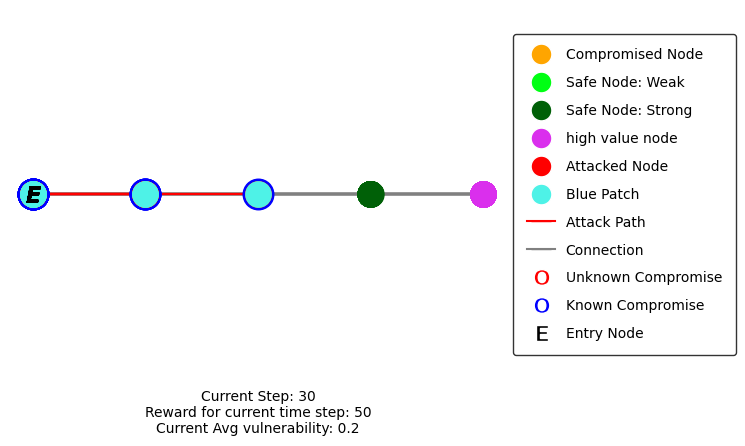

In [141]:
loop = ActionLoop(eval_env, s_agent, episode_count=1)
loop2 = loop.gif_action_loop(save_gif=True, render_network=True, gif_output_directory='.\gifs', webm_output_directory='.\gifs')
print(loop2)
#loop2 = loop.gif_action_loop(save_gif=True, render_network=True, gif_output_directory='.\gifs', webm_output_directory='.\gifs')

In [110]:
print(loop2[0]['info'][28])

{'initial_state': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0, '51ca4906-074f-4855-9fd9-0a16e76a77ca': 1, '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0, '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0, 'f16940e7-9b3b-438c-b34f-832030c0ea80': 0}, 'initial_blue_view': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0, '51ca4906-074f-4855-9fd9-0a16e76a77ca': 1, '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0, '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0, 'f16940e7-9b3b-438c-b34f-832030c0ea80': 0}, 'initial_vulnerabilities': {'86291e7c-5b6a-4c23-bd0c-094e933ae5e6': 0.8, '51ca4906-074f-4855-9fd9-0a16e76a77ca': 0.20000000000000007, '5fd61d92-6050-4aac-b4f4-0f159adb8456': 0.4000000000000001, '60fb528d-9c8b-4295-b232-8c9693bf3dc8': 0.4000000000000001, 'f16940e7-9b3b-438c-b34f-832030c0ea80': 0.01}, 'initial_red_location': Node(uuid='51ca4906-074f-4855-9fd9-0a16e76a77ca', name='PC 2', high_value_node=False, entry_node=False, vulnerability=0.8, x_pos=-0.5, y_pos=0.01), 'initial_graph': {Node(uuid='86291e7c-5b6a-4c23-bd0c-0

In [156]:
import numpy
obs = eval_env.reset()
print(type(obs[30]))
val = 0
print(type(numpy.float32(val)))
print(obs)

<class 'numpy.float32'>
<class 'numpy.float32'>
[0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.  0.  1.  0.  0.  0.  1.
 0.  1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8
 0.8 0.8 0.8 0.8 1.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]


# Predictions for evaluation


In [157]:


import random

random.seed(10)

#get sample 

r_c1 = []
for i in range(0, 1000):
    a = random.randint(0, 1)
    r_c1.append(a)
    
r_c2 = []
for i in range(0, 1000):
    a = random.randint(0, 1)
    r_c2.append(a)

r_c3 = []
for i in range(0, 1000):
    a = random.randint(0, 1)
    r_c3.append(a)
    
r_c4 = []
for i in range(0, 1000):
    a = random.randint(0, 1)
    r_c4.append(a)


In [158]:
from random import choices
random.seed(10)

vulns = [0.01,0.2,0.4,0.6,0.8]

r_v1 = choices(vulns, k=1000)
r_v2 = choices(vulns, k=1000)
r_v3 = choices(vulns, k=1000)
r_v4 = choices(vulns, k=1000)
r_v5 = choices(vulns, k=1000)

In [169]:
obs = eval_env.reset()
obs[30] = r_c1[0]
obs[31] = r_c2[0]
obs[32] = r_c3[0]
obs[33] = r_c4[0]

obs[35] = r_v1[0]
obs[36] = r_v2[0]
obs[37] = r_v3[0]
obs[38] = r_v4[0]
obs[39] = r_v5[0]

print(obs)

p = s_agent.predict(obs, deterministic= True)
a = p[0].astype(int).item()


[0.   1.   0.   0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   1.
 0.   0.   0.   1.   0.   1.   0.   0.   0.   1.   0.   0.   0.   0.
 0.   0.   0.   0.   1.   1.   0.   0.4  0.01 0.4  0.4  0.6  1.   0.
 0.   0.   0.   0.   0.   0.   0.   1.  ]
<class 'int'>


In [172]:
a_agent = []

for i in range(1000):
    obs = eval_env.reset()
    obs[30] = r_c1[i]
    obs[31] = r_c2[i]
    obs[32] = r_c3[i]
    obs[33] = r_c4[i]

    obs[35] = r_v1[i]
    obs[36] = r_v2[i]
    obs[37] = r_v3[i]
    obs[38] = r_v4[i]
    obs[39] = r_v5[i]
    p = s_agent.predict(obs, deterministic= True)
    a = p[0].astype(int).item()
    
    a_agent.append(a)


zip_a = list(zip(a_agent))

df_a = pd.DataFrame(zip_a, columns=['Agent action'])

print(df_a.head(30))

df_a.to_csv('a_agent_df.csv')


    Agent action
0              5
1              3
2              1
3              4
4              3
5              3
6              5
7              3
8              3
9              5
10             5
11             5
12             5
13             3
14             5
15             3
16             1
17             5
18             3
19             5
20             5
21             5
22             3
23             5
24             5
25             5
26             3
27             5
28             3
29             1


In [174]:
## Retrieve sample

import random

random.seed(11)

#get sample 

r_c1 = []
for i in range(0, 20000):
    a = random.randint(0, 1)
    r_c1.append(a)
    
r_c2 = []
for i in range(0, 20000):
    a = random.randint(0, 1)
    r_c2.append(a)

r_c3 = []
for i in range(0, 20000):
    a = random.randint(0, 1)
    r_c3.append(a)
    
r_c4 = []
for i in range(0, 20000):
    a = random.randint(0, 1)
    r_c4.append(a)

from random import choices

vulns = [0.01,0.2,0.4,0.6,0.8]

r_v1 = choices(vulns, k=20000)
r_v2 = choices(vulns, k=20000)
r_v3 = choices(vulns, k=20000)
r_v4 = choices(vulns, k=20000)
r_v5 = choices(vulns, k=20000)

a_agent_train = []
next_states = []

for i in range(20000):
    obs = eval_env.reset()
    obs[30] = r_c1[i]
    obs[31] = r_c2[i]
    obs[32] = r_c3[i]
    obs[33] = r_c4[i]

    obs[35] = r_v1[i]
    obs[36] = r_v2[i]
    obs[37] = r_v3[i]
    obs[38] = r_v4[i]
    obs[39] = r_v5[i]
    p = s_agent.predict(obs, deterministic= True)
    a = p[0].astype(int).item()

    a_agent_train.append(a)
    


zip_train = list(zip(a_agent_train, r_c1, r_c2, r_c3, r_c4, r_v1, r_v2, r_v3, r_v4, r_v5))

df_train = pd.DataFrame(zip_train, columns=['Action', 'c1', 'c2', 'c3', 'c4', 'v1', 'v2', 'v3', 'v4', 'v5'])

print(df_train.head(30))

df_train.to_csv('a_agent_train_df.csv')


    Action  c1  c2  c3  c4    v1    v2    v3    v4    v5
0        1   1   1   0   0  0.40  0.01  0.60  0.80  0.60
1        3   1   0   1   0  0.40  0.80  0.80  0.20  0.40
2        5   1   0   1   1  0.40  0.40  0.20  0.40  0.60
3        5   0   0   0   1  0.01  0.80  0.80  0.80  0.80
4        1   0   1   0   0  0.01  0.60  0.60  0.01  0.20
5        5   1   0   0   1  0.40  0.60  0.01  0.01  0.60
6        3   0   1   1   0  0.60  0.80  0.60  0.01  0.20
7        5   0   1   1   1  0.80  0.20  0.01  0.40  0.40
8        5   1   0   1   1  0.20  0.20  0.01  0.01  0.40
9        1   1   1   0   0  0.80  0.20  0.40  0.20  0.60
10       8   0   0   0   0  0.01  0.80  0.40  0.60  0.80
11       4   0   0   0   0  0.80  0.80  0.60  0.80  0.20
12       1   0   1   0   0  0.80  0.20  0.40  0.20  0.60
13       3   1   1   1   1  0.60  0.60  0.40  0.60  0.60
14       3   1   1   1   1  0.20  0.20  0.80  0.20  0.01
15       3   0   1   1   0  0.20  0.20  0.40  0.01  0.80
16       5   0   1   1   1  0.8